# <center>**Backtesting - by matrix**<center/>         

In [1]:
import pandas as pd
import numpy as np
import warnings
import gc
import os 
import sys
from IPython.core.interactiveshell import  InteractiveShell
pd.set_option('max.rows',200)
pd.set_option('max.columns',100)
warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all"

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.mpl.rcParams['figure.figsize'] = (8.0, 4.0)

# display Chinese in pictures
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=15)
sns.set(font=myfont.get_name())

# display minus operations 
sns.mpl.rcParams['axes.unicode_minus']=False

# colormap 
cm = sns.light_palette('blue',as_cmap=True)

In [3]:
from tqdm import tqdm

#### **data**

In [4]:
data = pd.read_pickle('data')
date_list = data.index.tolist()

In [5]:
# matched data 
import json 
# match result by matrix
match_by_matrix = json.load(open('..\\match_result\\match_by_matrix.json'))

## **Ⅰ forecast**       

In [6]:
split_date_list = list(match_by_matrix.keys())

In [7]:
# jenks natural breaks 
import itertools 

def jenks_natural_break_pre(data:'array-like',num_point:'sample in each group'=3):
    # variance 
    var = np.inf 
    pre = 0 
    for value in itertools.combinations(data,num_point):
        if np.var(value) < var:
            pre = np.mean(value)
    return pre

In [8]:
%%time
average_matrix_pre = []   
weight_matrix_pre = []
jenks_matrix_pre = []    

for split_date in tqdm(split_date_list):
    
    # matched data 
    daily_match_by_matrix = match_by_matrix[split_date]
    matched_data = [data[start_date:][20:40].values for start_date,_ in daily_match_by_matrix]       
    
    weight = np.array([w for _,w in daily_match_by_matrix])
    weight /= sum(weight)
    
    # average forecast 
    average_pre = np.sum(matched_data, 0) / len(matched_data)
    average_matrix_pre.append(average_pre)       
    
    # weight forecast 
    weight_pre = np.sum([matched_data[i]*weight[i] for i in range(len(matched_data))],0)
    weight_matrix_pre.append(weight_pre)
    
    # jenks natural breaks forecast  
    jenks_pre_list = []
    for i in range(28):
        jenks_pre_list.append(np.apply_along_axis(jenks_natural_break_pre,0,np.vstack([item[:,i] for item in matched_data])))
    jenks_matrix_pre.append(np.array(jenks_pre_list).T)

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:14<00:00,  3.98it/s]

Wall time: 14.6 s


## **Ⅱ portfolio**

In [9]:
import statsmodels.api as sm 

In [10]:
def cal_slope(y:'array like'):
    x = np.arange(0,len(y),1)
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    fit_result = model.fit()
    return fit_result.params[1]

In [11]:
%%time
# construct portfolio            

# top predicted return            
average_top = {}        
weight_top = {} 
jenks_top = {} 
# bottom predicted return 
average_bottom = {} 
weight_bottom = {} 
jenks_bottom = {} 

for date,average_pre,weight_pre,jenks_pre in zip(split_date_list,average_matrix_pre,weight_matrix_pre,jenks_matrix_pre):
    # average  
    average_pre = pd.DataFrame(average_pre,columns=data.columns)
    average_slope = average_pre.apply(cal_slope).sort_values(ascending=False)
    average_top[date] = average_slope[:5].to_dict()
    average_bottom[date] = average_slope[-5:].to_dict()
    
    # weight 
    weight_pre = pd.DataFrame(weight_pre,columns=data.columns)
    weight_slope = weight_pre.apply(cal_slope).sort_values(ascending=False)
    weight_top[date] = weight_slope[:5].to_dict()
    weight_bottom[date] = weight_slope[-5:].to_dict()
    
    # jenks 
    jenks_pre = pd.DataFrame(jenks_pre, columns=data.columns)
    jenks_slope = jenks_pre.apply(cal_slope).sort_values(ascending=False)
    jenks_top[date] = jenks_slope[:5].to_dict()
    jenks_bottom[date] = jenks_slope[-5:].to_dict()

Wall time: 5.13 s


## **Ⅲ backtest**

In [14]:
from backtest import *

In [12]:
# return 
data_ret = data.pct_change()

In [15]:
# test data 
test_data = data[data.index>split_date_list[0]][20:].mean(1).values
test_data /= test_data[0]

### **Ⅲ-① backtest long only**

In [16]:
%%time 
# backtest result 
average_longonly_result = long_only_backtest(date_list,split_date_list,data_ret,average_top)
weight_longonly_result = long_only_backtest(date_list,split_date_list,data_ret,weight_top)
jenks_longonly_result = long_only_backtest(date_list,split_date_list,data_ret,jenks_top)

Wall time: 3.13 s


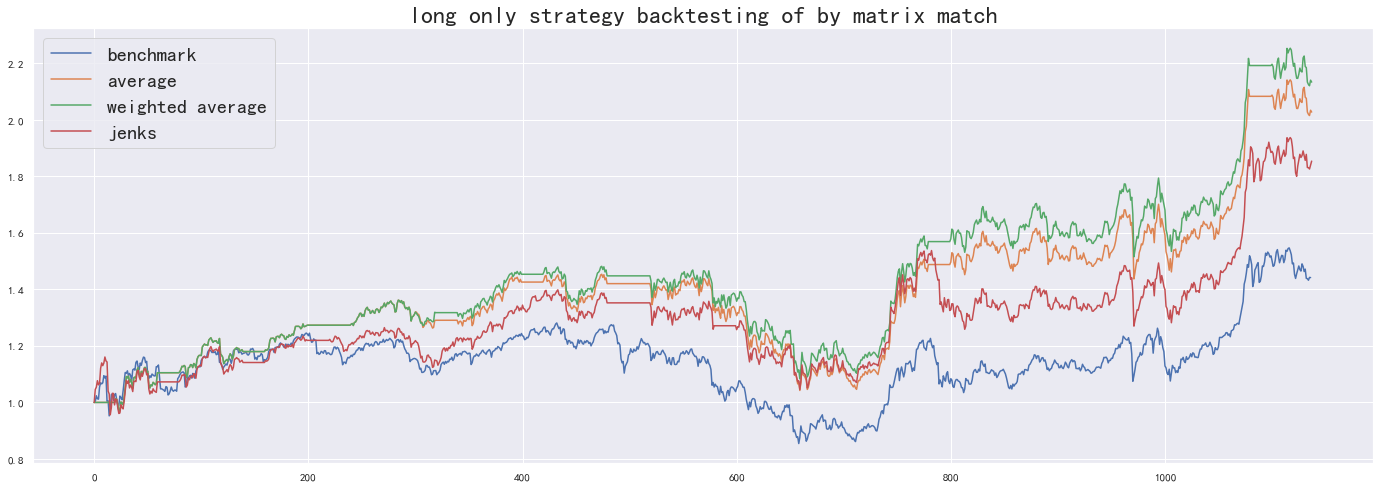

In [17]:
plt.figure(figsize=(24,8))
plt.plot(test_data)
plt.plot(average_longonly_result)
plt.plot(weight_longonly_result)
plt.plot(jenks_longonly_result)
plt.legend(['benchmark','average','weighted average','jenks'],fontsize=20)
plt.title('long only strategy backtesting of by matrix match',size=24);

In [20]:
backtest_stat = {} 
backtest_stat['average'] = general_stat(average_longonly_result)
backtest_stat['weight'] = general_stat(weight_longonly_result)
backtest_stat['jenks'] = general_stat(jenks_longonly_result)
pd.DataFrame(backtest_stat).style.background_gradient(cmap=cm,axis=1)

,average,weight,jenks
annualized return,16.795564,18.110843,14.521574
maximum drawdown,0.282833,0.268834,0.252215
sharpe ratio,0.913658,0.969697,0.736119
annualized vol,0.189885,0.190619,0.216341


### **Ⅲ-② long short**

In [21]:
%%time
average_longshort_result = long_short_backtest(date_list,split_date_list,data_ret,average_top,average_bottom)
weight_longshort_result = long_short_backtest(date_list,split_date_list,data_ret,weight_top,weight_bottom)
jenks_longshort_result = long_short_backtest(date_list,split_date_list,data_ret,jenks_top,jenks_bottom)

Wall time: 5.73 s


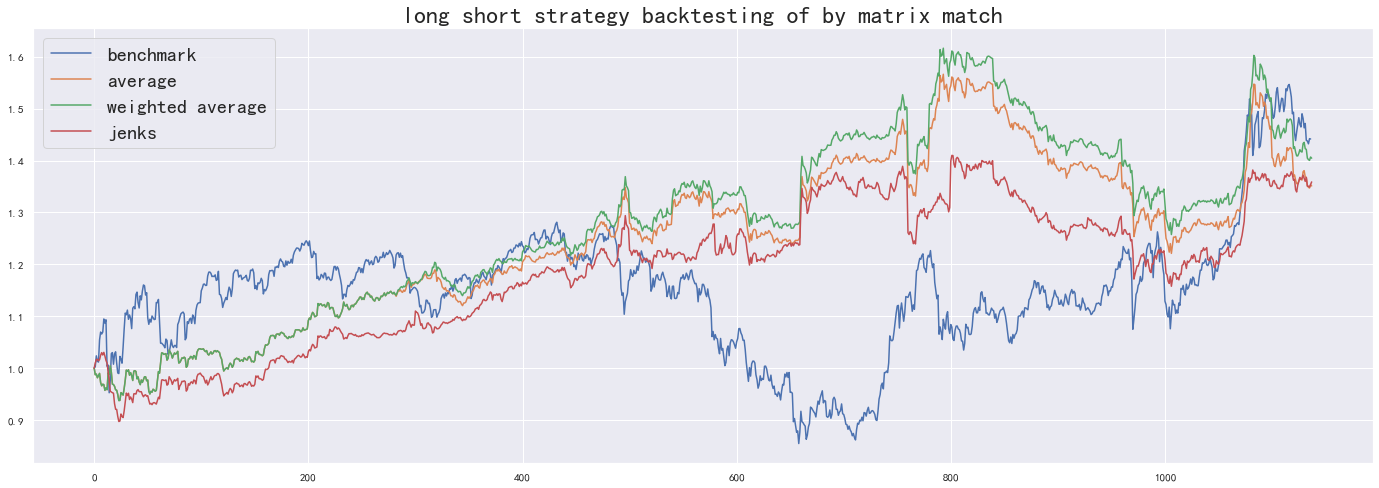

In [22]:
plt.figure(figsize=(24,8))
plt.plot(test_data)
plt.plot(average_longshort_result)
plt.plot(weight_longshort_result)
plt.plot(jenks_longshort_result)
plt.legend(['benchmark','average','weighted average','jenks'],fontsize=20)
plt.title('long short strategy backtesting of by matrix match',size=24);

In [23]:
backtest_longshort_stat = {} 
backtest_longshort_stat['average'] = general_stat(average_longshort_result)
backtest_longshort_stat['weight'] = general_stat(weight_longshort_result)
backtest_longshort_stat['jenks'] = general_stat(jenks_longshort_result)
pd.DataFrame(backtest_longshort_stat).style.background_gradient(cmap=cm,axis=1)

,average,weight,jenks
annualized return,6.836666,7.751114,6.970045
maximum drawdown,0.220456,0.222224,0.178900
sharpe ratio,0.613756,0.683572,0.649293
annualized vol,0.119478,0.119811,0.113863
